In [25]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [26]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
r = praw.Reddit(client_id='GJtzNYyCMIW-66t_xry24Q',
                     client_secret='ClyB_Id7qbhShlg4P43xqrLiyXPvyA',
                     user_agent='ljx597620034')

In [30]:
subreddit = r.subreddit('Nike')

shoes = [*subreddit.top(limit=None)] # top posts all time

print(len(shoes))

999


In [31]:
shoes0 = shoes[0]

# pprint(vars(news0)) 
print(shoes0.title) # headline
print(shoes0.score) # upvotes
print(shoes0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(shoes0.created)) # date and time
print(shoes0.num_comments) # no. of comments
print(shoes0.upvote_ratio) # upvote / total votes
print(shoes0.total_awards_received) # no. of awards given

Yea I was that mom that messaged Nike asking questions 😅. Thought it wouldn't hurt to spam the internet to get Nike shoes to look at accommodating kids with special needs. To date we've yet to find a shoe that actually fits with Maddy's AFOs.
1397
1612239524.0
2021-02-01 23:18:44
48
0.99
14


In [33]:
title = [shoes.title for shoes in shoes]
shoes = pd.DataFrame({
    "title": title,
})
shoes.head()

,title
0,Yea I was that mom that messaged Nike asking q...
1,I made this hat out of 90’s Nike tags I sewed ...
2,😶
3,Nike Logo
4,A pair of custom Charizard Nikes my dad got me...


In [34]:
sid = SentimentIntensityAnalyzer()

pos_text = "Vader is awesome"
cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect
neg_text = "Vader is bad"

print(sid.polarity_scores(pos_text))
print(sid.polarity_scores(cap_pos_text))
print(sid.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


In [35]:
res = [*shoes['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.764, 'neg': 0.0, 'neu': 0.841, 'pos': 0.159},
 {'compound': 0.4588, 'neg': 0.0, 'neu': 0.769, 'pos': 0.231},
 {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}]


In [36]:
sentiment_df = pd.DataFrame.from_records(res)
shoes = pd.concat([shoes, sentiment_df], axis=1, join='inner')
shoes.head()

,title,neg,neu,pos,compound
0,Yea I was that mom that messaged Nike asking q...,0.0,0.841,0.159,0.7640
1,I made this hat out of 90’s Nike tags I sewed ...,0.0,0.769,0.231,0.4588
2,😶,0.0,0.000,0.000,0.0000
3,Nike Logo,0.0,1.000,0.000,0.0000
4,A pair of custom Charizard Nikes my dad got me...,0.0,0.759,0.241,0.6597


In [38]:
THRESHOLD = 0.2

conditions = [
    (shoes['compound'] <= -THRESHOLD),
    (shoes['compound'] > -THRESHOLD) & (shoes['compound'] < THRESHOLD),
    (shoes['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
shoes['label'] = np.select(conditions, values)

shoes.head()

,title,neg,neu,pos,compound,label
0,Yea I was that mom that messaged Nike asking q...,0.0,0.841,0.159,0.7640,pos
1,I made this hat out of 90’s Nike tags I sewed ...,0.0,0.769,0.231,0.4588,pos
2,😶,0.0,0.000,0.000,0.0000,neu
3,Nike Logo,0.0,1.000,0.000,0.0000,neu
4,A pair of custom Charizard Nikes my dad got me...,0.0,0.759,0.241,0.6597,pos


In [39]:
sentence0 = shoes.title.iloc[0]
print(sentence0)
words0 = shoes.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0: 
    if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
        pos_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
        neg_list.append(word)
    else:
        neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
print(f"\nThis sentence is NEGATIVE")

Yea I was that mom that messaged Nike asking questions 😅. Thought it wouldn't hurt to spam the internet to get Nike shoes to look at accommodating kids with special needs. To date we've yet to find a shoe that actually fits with Maddy's AFOs.
['Yea', 'I', 'was', 'that', 'mom', 'that', 'messaged', 'Nike', 'asking', 'questions', '😅.', 'Thought', 'it', "wouldn't", 'hurt', 'to', 'spam', 'the', 'internet', 'to', 'get', 'Nike', 'shoes', 'to', 'look', 'at', 'accommodating', 'kids', 'with', 'special', 'needs.', 'To', 'date', "we've", 'yet', 'to', 'find', 'a', 'shoe', 'that', 'actually', 'fits', 'with', "Maddy's", 'AFOs.']

Positive: ['special']
Neutral: ['Yea', 'I', 'was', 'that', 'mom', 'that', 'messaged', 'Nike', 'asking', 'questions', '😅.', 'Thought', 'it', "wouldn't", 'to', 'the', 'internet', 'to', 'get', 'Nike', 'shoes', 'to', 'look', 'at', 'accommodating', 'kids', 'with', 'needs.', 'To', 'date', "we've", 'yet', 'to', 'find', 'a', 'shoe', 'that', 'actually', 'fits', 'with', "Maddy's", 'AF

In [41]:
shoes.label.value_counts()


neu    630
pos    299
neg     70
Name: label, dtype: int64

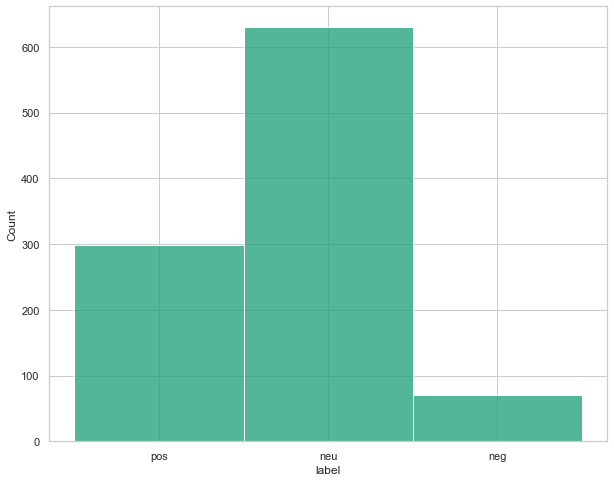

In [42]:
sns.histplot(shoes.label);

In [43]:
def shoes_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
shoes_sub = shoes.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
shoes_title_output(shoes_sub, "pos")

print("\nNeutral news")
shoes_title_output(shoes_sub, "neu")

print("\nNegative news")
shoes_title_output(shoes_sub, "neg")

Positive news
Sold out? Don't they drop on the 30th?
Micro Nike SB Dunk High by Steven Natali at Electric Vision Tattoo. Seattle, WA
Got my first two running shoes the other day. Nike ID’d em. Warmer weather is coming.
Customshoes if you like
Best shoe of the year so far???

Neutral news
I sketched on a white canvas t shirt for Air Max Day. A simple story of the first Air Max 1 “swipa”.
Another L
My Air Force 1 High “By You” finally arrived 💪🏽💪🏽
My first pair of AF1s!
UNDERCOVER DAYBREAK

Negative news
This represents my Nike v Adidas preference - no hate for Adidas, just less love for Adidas
[custom] Took a while but they're done. Would you rock or drop?
Destroyed my dirty denim dunk lows. At least they resemble the name they were given 😂
Nike Dunk Low "Un-Argon" (2005) 309431-411
Struckout today but no worries just pulled out the 2001 pair in my collection


In [48]:
stop_words = stopwords.words('english')
def custom_tokenize(text): 
  # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()

  # split on words only 
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')  
    tokens = tk.tokenize(text)
    

  # remove stop words
    words = [w for w in tokens if not w in stop_words] 
    return words

In [50]:
def tokens_2_words(df, label):
  # subset titles based on label
    titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

pos_words = tokens_2_words(shoes, 'pos')
neg_words = tokens_2_words(shoes, 'neg')

In [51]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('nike', 78),
 ('air', 35),
 ('first', 32),
 ('love', 31),
 ('like', 25),
 ('jordan', 25),
 ('made', 24),
 ('pair', 24),
 ('got', 23),
 ('shoes', 22),
 ('1', 20),
 ('max', 19),
 ('favorite', 18),
 ('look', 16),
 ('get', 15),
 ('best', 15),
 ('happy', 14),
 ('custom', 13),
 ('day', 12),
 ('one', 12)]

In [56]:
pos_im = [str(p) for p in pos_words] 
pos_str = ",".join(pos_im) 
neg_im = [str(p) for p in neg_words] 
neg_str = ",".join(neg_im)

<function matplotlib.pyplot.show(close=None, block=None)>

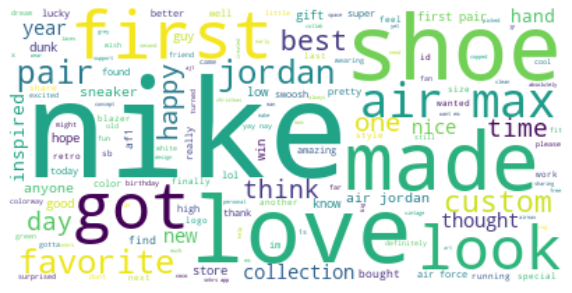

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_cloud_pos = WordCloud(background_color = "white").generate(pos_str)
word_cloud_neg = WordCloud().generate(neg_str)
plt.imshow(word_cloud_pos,interpolation = "bilinear") 
plt.axis("off") 
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

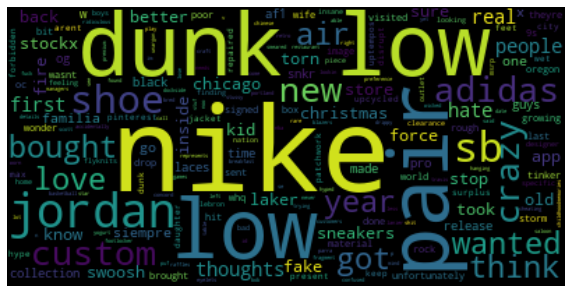

In [63]:
plt.imshow(word_cloud_neg,interpolation = "bilinear") 
plt.axis("off") 
plt.show 